In [106]:
import pandas as pd
from pathlib import Path
import csv
import numpy as np
import os
from datetime import datetime, timedelta
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import json
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import scipy as sp
import sklearn as sk
import keras
import pandas_datareader as web
from pandas import Series
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import array
from math import sqrt
import hvplot.pandas

In [107]:
load_dotenv()

Python-dotenv could not parse statement starting at line 14


True

In [108]:
alpaca_public = os.getenv("ALPACA_API_KEY")
alpaca_secret = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_public, alpaca_secret, api_version='v2')

In [109]:
assets = api.list_assets()
tradeable = [asset for asset in assets if asset.tradable]

In [110]:
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

In [111]:
main_df = pd.DataFrame()
screened_stocks_df = pd.read_csv('../Data/REIT_stocks.csv')
screened_stocks_tickers = screened_stocks_df['Ticker']
tickers= screened_stocks_tickers.tolist()

In [112]:
read_stocks = web.DataReader(tickers, 'yahoo',start_date,end_date)
close_stocks = read_stocks['Close']
close_stocks.head()

C:\Users\andre\anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'AIII', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


Symbols,ACC,AHH,AIV,AMH,APTS,AVB,BOWFF,BRG,BRT,CPT,...,OPI,RESI,RPT,SNR,SRC,SUI,UDFI,UDR,UMH,AIII
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,47.110001,16.180000,49.340000,23.879999,15.880000,201.160004,29.010000,11.10,13.99,100.389999,...,26.780001,9.93,12.24,5.63,41.029999,123.769997,4.90,44.500000,13.97,NaN
2019-05-02,47.150002,15.410000,49.060001,24.010000,15.740000,201.440002,28.870001,11.10,14.00,99.980003,...,26.299999,9.94,12.54,5.59,42.400002,123.839996,4.91,44.259998,13.89,NaN
2019-05-03,47.310001,16.030001,50.049999,24.280001,16.059999,202.160004,29.010000,11.29,14.05,100.830002,...,28.410000,10.29,12.78,6.09,41.700001,123.709999,5.00,44.470001,13.95,NaN
2019-05-06,47.110001,16.420000,49.759998,24.160000,16.100000,200.570007,29.010000,11.40,14.19,100.889999,...,28.030001,10.07,12.84,6.11,42.150002,123.919998,5.00,44.369999,13.65,NaN
2019-05-07,46.250000,16.160000,49.080002,23.660000,15.920000,196.789993,29.010000,11.11,14.18,99.070000,...,26.889999,10.03,12.45,6.01,41.509998,121.839996,4.85,43.549999,13.15,NaN


In [113]:
#close_stocks.to_csv(r'../Data/REIT_data_update.csv')

In [114]:
REIT_stocks = pd.read_csv('../Data/REIT_data_update.csv', index_col='Date')

In [115]:
REIT_stocks

,ACC,AHH,AIV,AMH,APTS,AVB,BOWFF,BRG,BRT,CPT,...,OPI,RESI,RPT,SNR,SRC,SUI,UDFI,UDR,UMH,AIII
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,47.110001,16.180000,49.340000,23.879999,15.880000,201.160004,29.010000,11.10,13.99,100.389999,...,26.780001,9.93,12.24,5.630,41.029999,123.769997,4.90,44.500000,13.97,NaN
2019-05-02,47.150002,15.410000,49.060001,24.010000,15.740000,201.440002,28.870001,11.10,14.00,99.980003,...,26.299999,9.94,12.54,5.590,42.400002,123.839996,4.91,44.259998,13.89,NaN
2019-05-03,47.310001,16.030001,50.049999,24.280001,16.059999,202.160004,29.010000,11.29,14.05,100.830002,...,28.410000,10.29,12.78,6.090,41.700001,123.709999,5.00,44.470001,13.95,NaN
2019-05-06,47.110001,16.420000,49.759998,24.160000,16.100000,200.570007,29.010000,11.40,14.19,100.889999,...,28.030001,10.07,12.84,6.110,42.150002,123.919998,5.00,44.369999,13.65,NaN
2019-05-07,46.250000,16.160000,49.080002,23.660000,15.920000,196.789993,29.010000,11.11,14.18,99.070000,...,26.889999,10.03,12.45,6.010,41.509998,121.839996,4.85,43.549999,13.15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,29.879999,8.720000,35.090000,23.020000,6.740000,158.380005,18.040001,5.68,8.85,83.690002,...,24.900000,12.32,5.27,2.690,26.000000,126.739998,1.75,36.290001,11.25,NaN
2020-04-27,32.630001,9.120000,36.570000,23.650000,7.090000,160.750000,19.379999,5.72,9.57,86.339996,...,25.600000,12.14,5.72,2.810,27.690001,136.039993,1.75,37.619999,12.18,NaN
2020-04-28,34.340000,9.840000,37.209999,23.580000,7.440000,162.470001,19.379999,5.86,9.79,86.419998,...,26.639999,11.99,6.47,2.900,29.030001,136.000000,1.75,37.759998,12.69,NaN


In [ ]:
def data_splitter(data):
    for column in data:
        

t+1 RMSE: 1.524431
t+2 RMSE: 2.506095
t+3 RMSE: 3.002735


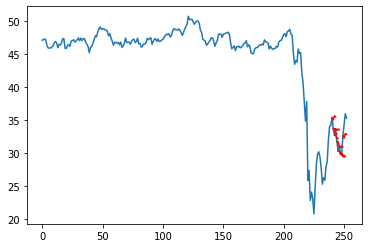

In [117]:
# date-time parsing function for loading the dataset
#def parser(x):
    #return datetime.strptime('%Y-%m-%d')
 
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw data
    raw_values = series.values
    #transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(diff_values), 1)
    
    # transform into a supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    #split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

#Fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    #reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    #design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X,y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make one forecast with an LSTM
def forecast_lstm(model, X, n_batch):
    #reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    #make forecast
    forecast = model.predict(X, batch_size=n_batch)
    #convert to an array
    return[x for x in forecast[0, :]]

def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        #invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evalueate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))
        
#plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    #plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    #show the plot
    plt.show()

    
#load dataset
series = REIT_stocks['ACC']
#configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1 #cant do anything larger than 1 bc in a stateful network the sample has to be divisible by the batch and this network has 239 examples & 239 is prime
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
#fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
#evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
#plot forecasts
plot_forecasts(series, forecasts, n_test+2)